<a href="https://colab.research.google.com/github/fshi3/RL_stock_trading/blob/master/RL_Stock_Trading_Custom_Reward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Reinforcement Learning Final Project - Stock Trading Algorithm</h1>
    
<br>
Implementation using the 
"anytrading" environment in OpenAIGym
<br>
https://github.com/AminHP/gym-anytrading

In [1]:
pip install gym-anytrading

     |████████████████████████████████| 171 kB 7.9 MB/s 


In [2]:
# importing the OpenAIGym Environment for stock trading
import gym
import gym_anytrading
from gym_anytrading.envs import Positions, Actions, StocksEnv
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from gym_anytrading.datasets import STOCKS_GOOGL
from gym.envs.registration import register
import random
from copy import deepcopy


In [3]:
class AdvancedEnv(StocksEnv):

  def __init__(self, df, window_size, frame_bound):
      super().__init__(df, window_size, frame_bound)
      self.trade_fee_bid_percent = 0  # unit
      self.trade_fee_ask_percent = 0  # unit

  def reset(self):
    obs = super().reset()
    self._total_reward = 1
    return obs

  def _update_mdd():
    pass

  def update_sharpe():
    pass

  def _get_observation(self):
      obs = self.signal_features[(self._current_tick-self.window_size):self._current_tick]
      obs = np.array(obs)
      prices = obs[1:, 1]
      changes = obs[:-1, 0]
      opt = prices/changes
      return opt

  def step(self, action):
    self._done = False
    self._current_tick += 1

    if self._current_tick == self._end_tick:
            self._done = True

    step_reward = self._calculate_reward(action)
    self._total_reward *= (1+step_reward)

    self._update_profit(action)

    trade = False
    if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True
    if trade:
        self._position = self._position.opposite()
        self._last_trade_tick = self._current_tick

    self._position_history.append(self._position)
    observation = self._get_observation()
    info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
    )
    self._update_history(info)

    return observation, step_reward, self._done, info
    
  def _calculate_reward(self, action):
        
        current_price = self.prices[self._current_tick]
        last_price = self.prices[self._current_tick-1]
    
        percent_diff = (current_price-last_price)/last_price
        
        if self._position == Positions.Short:
            return float(-percent_diff)
        else:
            return float(percent_diff)
            
        

In [4]:
register(
    id='advanced-stocks-v0',
    entry_point=AdvancedEnv,
    kwargs={
        'df': deepcopy(STOCKS_GOOGL),
        'window_size': 30,
        'frame_bound': (30, len(STOCKS_GOOGL))
    }
)

In [5]:
# Google Stock dataset
STOCKS_GOOGL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100
...,...,...,...,...,...,...
2018-08-23,1219.880005,1235.170044,1219.349976,1221.160034,1221.160034,1233300
2018-08-24,1226.000000,1237.400024,1221.420044,1236.750000,1236.750000,1222700
2018-08-27,1244.140015,1257.869995,1240.680054,1256.270020,1256.270020,1429000


In [6]:
env = gym.make('advanced-stocks-v0')
env_1 = gym.make('advanced-stocks-v0',
               df = STOCKS_GOOGL,
               window_size = 10,
               frame_bound = (1000, 1500))

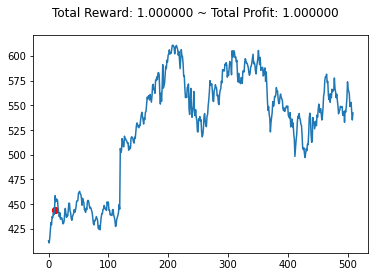

In [7]:
env_1.reset()
env_1.render()

Max_possible_profit signifies that if the market didn't have trade fees, you could have earned 12.468122338293616 units of currency by starting with 1.0. In other words, your money increased over 1200%.

In [8]:
env_1.max_possible_profit()

12.46812233829367

In [9]:
action = 1
print(env_1.step(action))

(array([ 0.0111892 ,  0.0194188 ,  0.01871775, -0.00501424,  0.01913142,
       -0.00246101,  0.01004036, -0.00306737,  0.01090562]), -0.0324540971036752, False, {'total_reward': 0.9675459028963248, 'total_profit': 1.0, 'position': 1})


In [10]:
observation, reward, done, info = env_1.step(action)

<h2>Random and Heuristic Methods:</h2>

<h3>Method 1: Random Buy/Sell</h3>

[-0.00502075  0.0111892   0.0194188   0.01871775 -0.00501424  0.01913142
 -0.00246101  0.01004036 -0.00306737]
info:  {'total_reward': 1.126847053846374, 'total_profit': 1.2073908859786089, 'position': 0}


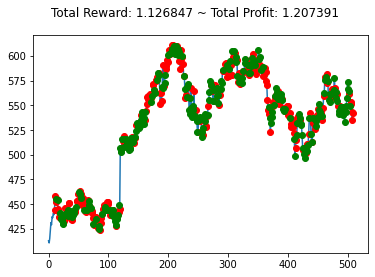

In [11]:
state = env_1.reset()
print(state)
while True:
    action = env_1.action_space.sample()
    state, reward, done, info = env_1.step(action)

    if done:
        print("info: ", info)
        break

env_1.render_all()

<h3>Method 2: Buy low sell high (last ten days moving average)</h3>

In [12]:
observation = env_1.reset()

last_ten_days = [] # moving average
moving_avg = 0
while True:
    if len(last_ten_days) < 10:
        last_ten_days.append(observation[0][0])
    else:
        last_ten_days.pop(0)
        last_ten_days.append(observation[0][0])
    moving_avg = sum(last_ten_days) / len(last_ten_days)
    
    
    if observation[0][0] < moving_avg:
        action = 1 # buy)
    elif observation[0][0] > moving_avg:
        action = 0 # sell
    
    observation, reward, done, info = env_1.step(action)
    #print(type(reward))
    if done:
        print("info: ", info)
        break

env_1.render_all()
    

IndexError: ignored

<h3>Method 3: Buy and Hold Strategy</h3>
<br>
Buy the stock at the beginning and hold throughout the period and sell stock at the very end.

In [ ]:
state = env_1.reset()
count = 0
while True:
    count += 1
    action = 1
    if count > 495:
        action = 0
    state, reward, done, info = env_1.step(action)
    print(reward)
    if done:
        print("info: ", info)
        break

env_1.render_all()

<h2>Reinforcement Learning Methods:</h2>

<h3>Method 4: Deep Q-Learning (DQN)</h3>

In [13]:
# Parameters
gamma = 0.99
actsize = env_1.action_space.n
obssize = env_1.observation_space.low.size
window_size = 10

In [14]:
def model_creator():
    model = keras.Sequential()
    model.add(layers.Dense(128,activation="relu",  dtype='float64', input_shape=(window_size,)))
    model.add(layers.Dense(500,activation="relu"))
    model.add(layers.Dense(1000,activation="relu"))
    model.add(layers.Dense(actsize,activation="linear"))
    return model

In [15]:
batch_size = 10
# Model used for selecting actions (principal)
model = model_creator()
# Then create the target model. This will periodically be copied from the principal network 
model_target = model_creator()

model.build((batch_size,obssize,))
model_target.build((batch_size,obssize,))

**Training the Model:**

In [19]:
# environment for training
env_training = gym.make('advanced-stocks-v0', df = STOCKS_GOOGL, window_size = window_size+1, frame_bound = (window_size+1, 1500))

In [ ]:
#tf.keras.backend.set_floatx('float64')

In [17]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)


    # Our Experience Replay memory 
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
running_rewards_history = []

# Replay memory size
max_memory = 100 # You can experiment with different sizes.



update_after_actions = 4

# How often to update the target network
target_update_every = 50
loss_function = keras.losses.MeanSquaredError()

epochs = 20


def train(model, env, epsilon, adpative=True):

    for epoch in range(epochs):
      running_reward = 0
      timestep_count = 0

      #epsilon = 1
      #adpative = True
      #if adpative:
      #  epsilon = np.exp(-1e-2 * timestep_count)
      epsilon = 1 - (epoch+1)/epochs
      state = env_training.reset()
      while True:
          timestep_count += 1

          # adpative epsilon decay


          # exploration
          rand = np.random.uniform(0, 1)
          if rand < epsilon:
              # Take random action
              action = np.random.choice(actsize)
          else:
              # Predict action Q-values
              # From environment state
              state_t = tf.convert_to_tensor(state)
              state_t = tf.expand_dims(state_t, 0)
              action_vals = model(state_t, training=False)
              # Choose the best action
              action = int(tf.keras.backend.argmax(action_vals))

          state_next, reward, done, info = env_training.step(action)
          #state_next = state_next[0]


          # Save action/states and other information in replay buffer
          action_history.append(action)
          state_history.append(state)
          state_next_history.append(state_next)
          rewards_history.append(reward)
          done_history.append(done)
          running_rewards_history.append(info['total_reward'])

          running_reward = info['total_reward']

          state = state_next

          # Update every Xth frame to speed up (optional)
          # and if you have sufficient history
          if timestep_count % update_after_actions == 0 and len(action_history) > batch_size:
              # Sample a set of batch_size memories from the history
              rand_samples = np.random.randint(0, len(action_history), batch_size)

              action_sample = np.array(action_history)[rand_samples]
              state_sample = np.array(state_history)[rand_samples]
              state_next_sample = np.array(state_next_history)[rand_samples]
              rewards_sample = np.array(rewards_history)[rand_samples]
              done_sample = np.array(done_history)[rand_samples]

              # Create for the sample states the targets (r+gamma * max Q(...)
              state_next_sample_t = tf.convert_to_tensor(state_next_sample)
              Q_next_state = np.max(model_target.predict(state_next_sample_t), axis=1)   
              Q_targets = rewards_sample + gamma * Q_next_state

              # What actions are relevant and need updating
              relevant_actions = tf.cast(tf.one_hot(action_sample, actsize), tf.float32)

              # we will use Gradient tape to do a custom gradient 
              # in the `with` environment we will record a set of operations
              # and then we will take gradients with respect to the trainable parameters
              # in the neural network
              with tf.GradientTape() as tape:
                  # Train the model on your action selecting network
                  state_sample_t = tf.convert_to_tensor(np.asarray(state_sample))
                  q_values = model(state_sample_t) 
                  #print(q_values, relevant_actions)
                  # We consider only the relevant actions
                  Q_of_actions = tf.reduce_sum(tf.multiply(q_values, relevant_actions), axis=1)
                  # Calculate loss between principal network and target network
                  loss = loss_function(Q_targets, Q_of_actions)

                  # Nudge the weights of the trainable variables towards 
                  grads = tape.gradient(loss, model.trainable_variables)
                  optimizer.apply_gradients(zip(grads, model.trainable_variables))

          if timestep_count % target_update_every == 0:
              # update the the target network with new weights
              model_target.set_weights(model.get_weights())
              # Log details
              template = "running reward: {:.2f} at episode {}, info: {} epsilon {}"
              print(template.format(running_reward, timestep_count, info, epsilon))

          # Don't let the memory grow beyond the limit
          if len(rewards_history) > max_memory:
              del action_history[:1]
              del state_history[:1]
              del state_next_history[:1]
              del rewards_history[:1]
              del done_history[:1]

          if done:
              print("info: ", info)
              break
      print("Epoch " + str(epoch))
      env_training.render_all()

In [ ]:
# train on Google stock data from timestep 1 to 1000
train(model, env_training, 1, True)


In [ ]:
model.save("trained_model")

In [ ]:
# plot the running rewards
plt.plot(running_rewards_history)
plt.title("Running rewards during training")
plt.xlabel("Episodes")
plt.ylabel("Running Reward")

In [ ]:
# test model results on the next leg of the stock data from time 1000 to 1500
train(model, env_1, 0, False)

*The reward of the Deep Q Learning function after training for 1000 timesteps is: 186.441452 and the total profit is 1.5480215108859194. The initial money increased by 155%.*